Python code to reproduce figures from the paper. 

In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.simulators import UVVisExperiment, MinMaxScaler, scaled_tickformat
from botorch.utils.transforms import normalize
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [2]:
ITERATION = 14

In [3]:
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(ITERATION)
expt.generate(use_spline=True)

Loading data from iteration 0 with shapes: (12, 2) (12, 101)
Loading data from iteration 1 with shapes: (6, 2) (6, 101)
Loading data from iteration 2 with shapes: (6, 2) (6, 101)
Loading data from iteration 3 with shapes: (6, 2) (6, 101)
Loading data from iteration 4 with shapes: (6, 2) (6, 101)
Loading data from iteration 5 with shapes: (6, 2) (6, 101)
Loading data from iteration 6 with shapes: (6, 2) (6, 101)
Loading data from iteration 7 with shapes: (6, 2) (6, 101)
Loading data from iteration 8 with shapes: (6, 2) (6, 101)
Loading data from iteration 9 with shapes: (6, 2) (6, 101)
Loading data from iteration 10 with shapes: (6, 2) (6, 101)
Loading data from iteration 11 with shapes: (6, 2) (6, 101)
Loading data from iteration 12 with shapes: (6, 2) (6, 101)
Loading data from iteration 13 with shapes: (6, 2) (6, 101)


In [4]:
def prettify_axis(ax):
    """Code to modify design space axis

    This is an auxilary function to modfiy the axis
    from volumes to concentrations as well as make them
    look pretty with axis lines and tick labels.

    Parameters
    ----------
    ax : pyplot.axis
        axis object to plot on

    Returns
    -------
    pyplot.axis
        axis object modified tick labels and pretty-fied
    """
    ax.set_xlabel(r"Silver Nitrate ($10^{-4}$ M)")
    ax.set_ylabel(r"Ascorbic Acid ($10^{-3}$ M)")
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

    SN_labels = [item.get_text() for item in ax.get_xticklabels()]
    # convert volume to concentration using c1v1 = c2v2
    SN_vol_to_conc = lambda v : (6.4*v)/(300)
    SN_conc_labels = []
    for l in SN_labels:
        SN_conc_labels.append("%.2f"%SN_vol_to_conc(float(l)))
    ax.set_xticklabels(SN_conc_labels)

    AA_labels = [item.get_text() for item in ax.get_yticklabels()]
    AA_vol_to_conc = lambda v : (6.3*v)/(300)
    AA_conc_labels = []
    for l in AA_labels:
        AA_conc_labels.append("%.2f"%AA_vol_to_conc(float(l)))
    ax.set_yticklabels(AA_conc_labels)

    return ax

## 1. Plot training data collected from experiments on composition space

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


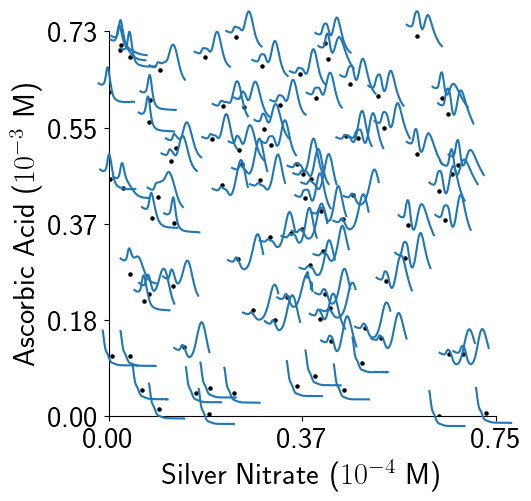

In [5]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    bounds = expt.bounds.cpu().numpy()
    scaler_x = MinMaxScaler(bounds[0,0], bounds[1,0])
    scaler_y = MinMaxScaler(bounds[0,1], bounds[1,1])

    ax.xaxis.set_major_formatter(lambda x, pos : scaled_tickformat(scaler_x, x, pos))
    ax.yaxis.set_major_formatter(lambda y, pos : scaled_tickformat(scaler_y, y, pos))
    train_comps = expt.comps
    norm_train_comps = normalize(train_comps, expt.bounds.cpu().numpy())
    train_spectra = expt.spectra_normalized 
    for i in range(train_comps.shape[0]):
        loc_ax = ax.transLimits.transform(norm_train_comps[i,:])
        ins_ax = ax.inset_axes([loc_ax[0]-0.03,loc_ax[1]-0.03,0.1,0.1])
        ins_ax.plot(expt.t, train_spectra[i,:])
        # ins_ax.set_ylim([0, 1.5])
        ins_ax.axis('off')    
    ax.scatter(train_comps[:,0], train_comps[:,1], color='k', s=5)
    prettify_axis(ax)
    plt.show()

## 2. Plot grid sample of trained model

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


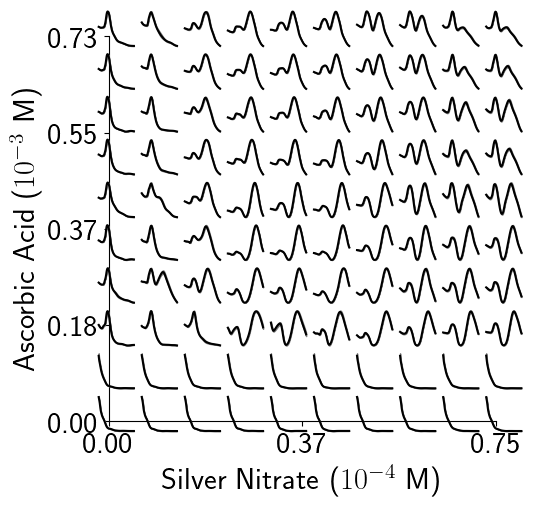

In [6]:
def plot_grid(grid_data):
    fig, ax = plt.subplots(figsize=(5,5))
    scaler_x = MinMaxScaler(design_space_bounds[0][0], design_space_bounds[0][1])
    scaler_y = MinMaxScaler(design_space_bounds[1][0], design_space_bounds[1][1])

    ax.xaxis.set_major_formatter(lambda x, pos : scaled_tickformat(scaler_x, x, pos))
    ax.yaxis.set_major_formatter(lambda y, pos : scaled_tickformat(scaler_y, y, pos))
    grid_comps = grid_data["comps"]
    grid_spectra = grid_data["spectra"]
    with torch.no_grad():
        for i, ci in enumerate(grid_comps):
            mu = grid_spectra[i, :, 0]  
            sigma = grid_spectra[i, :, 1]
            norm_ci = np.array([scaler_x.transform(ci[0]), scaler_y.transform(ci[1])])
            loc_ax = ax.transLimits.transform(norm_ci)
            ins_ax = ax.inset_axes([loc_ax[0]-0.03,loc_ax[1]-0.03,0.1,0.1])
            ins_ax.plot(expt.t, mu, color="k")
            ins_ax.fill_between(expt.t, mu-sigma, mu+sigma, color='grey')
            ins_ax.axis('off') 
    prettify_axis(ax)

    return fig, ax 

with plt.style.context(pyplot_style):
    grid_data = np.load("./data/grid_data_10_%d.npz"%ITERATION)
    plot_grid(grid_data)
    plt.show()

## 3. Plot Acquisiton function 

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


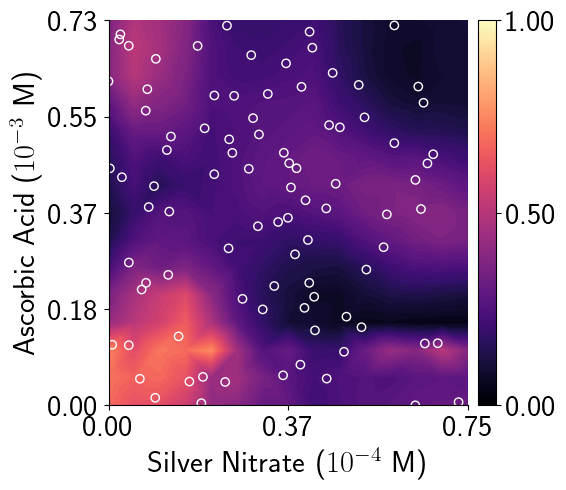

In [7]:
acqf_data = np.load("./data/acqf_data_%d.npz"%ITERATION)
C_grid = acqf_data["comps"]
acq_values = acqf_data["values"]
cmap = colormaps["magma"]
norm = Normalize(vmin=0, vmax = 1)
mappable = ScalarMappable(norm=norm, cmap=cmap)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.tricontourf(C_grid[:,0], C_grid[:,1], acq_values, cmap=cmap, norm=norm, levels=50)
    x_ = expt.comps
    ax.scatter(x_[:,0], x_[:,1], facecolors='none', edgecolors='w')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(3))
    cbar.ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    prettify_axis(ax)
    plt.show()

## 4. Plot train and test errors overs iterations

In [8]:
import pickle 

with open('./data/accuracies.pkl', 'rb') as handle:
    accuracies = pickle.load(handle)

In [9]:
train_errors, test_errors = [], []
for key, vals in accuracies.items():
    train_errors.append(vals["train"])
    if not key==len(accuracies):
        test_errors.append(vals["test"])

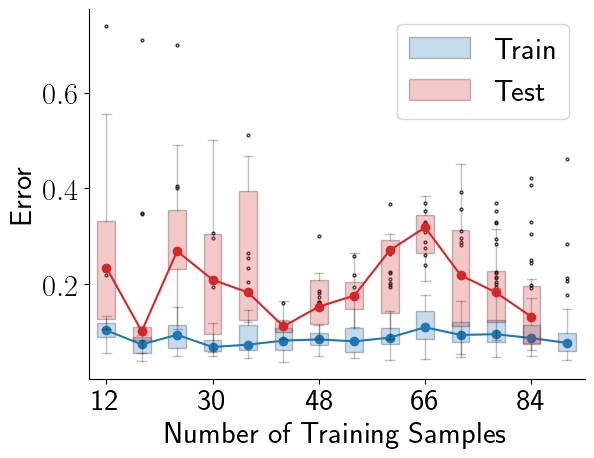

In [10]:
with plt.style.context(pyplot_style):
    xticks = [12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90]
    fig, ax = plt.subplots()
    median_props = {"color":"none"}
    flier_props = {"alpha": 0.75, "ms":2}
    cap_props = {"alpha" : 0.25}
    whisker_props = {"alpha" : 0.25}
    train_bplot = ax.boxplot(train_errors, 
                             patch_artist=True,
                             medianprops = median_props,
                             flierprops = flier_props,
                             capprops = cap_props,
                             whiskerprops = whisker_props
                             )
    ax.plot(np.arange(len(xticks))+1, 
            [np.median(a) for a in train_errors], 
            'o-', 
            color="tab:blue"
            )
    test_bplot = ax.boxplot(test_errors, 
                            patch_artist=True,
                            medianprops = median_props,
                            flierprops = flier_props,
                            capprops = cap_props,
                            whiskerprops = whisker_props
                            )
    ax.plot(np.arange(len(xticks)-1)+1, 
            [np.median(a) for a in test_errors], 
            'o-', 
            color="tab:red",
            )
    for patch in test_bplot['boxes']:
        patch.set_facecolor("tab:red")
        patch.set_alpha(0.25)
    for patch in train_bplot['boxes']:
        patch.set_alpha(0.25) 
             
    xtick_locs = np.arange(1, 14, 3)
    ax.set_xticks(xtick_locs)
    ax.set_xticklabels([xticks[i-1] for i in xtick_locs])

    ax.set_ylabel(r"Error")
    ax.set_xlabel("Number of Training Samples")
    ax.legend([train_bplot["boxes"][0], 
               test_bplot["boxes"][0]], 
               ['Train', 'Test'], 
               loc='upper right'
               ) 
    plt.show()

## 5. Fine-grid samples from latest iteration

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


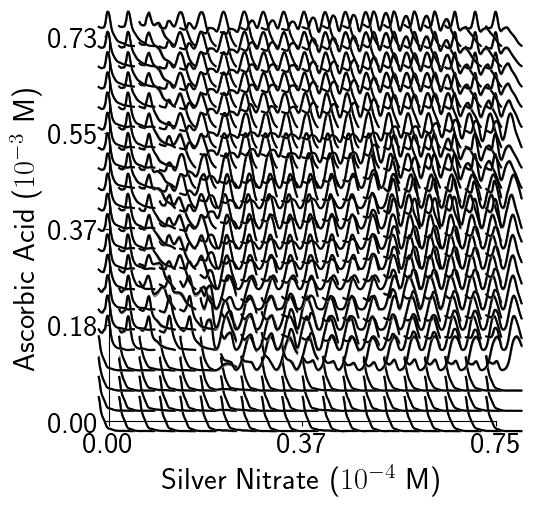

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


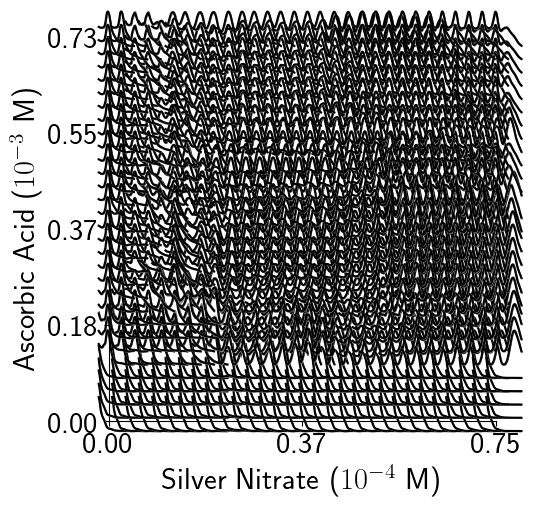

In [11]:
with plt.style.context(pyplot_style):
    grid_data = np.load("./data/grid_data_20.npz")
    plot_grid(grid_data)
    plt.show()

    grid_data = np.load("./data/grid_data_30.npz")
    plot_grid(grid_data)
    plt.show()

### Gradient based phasemap

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4058/121315157.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


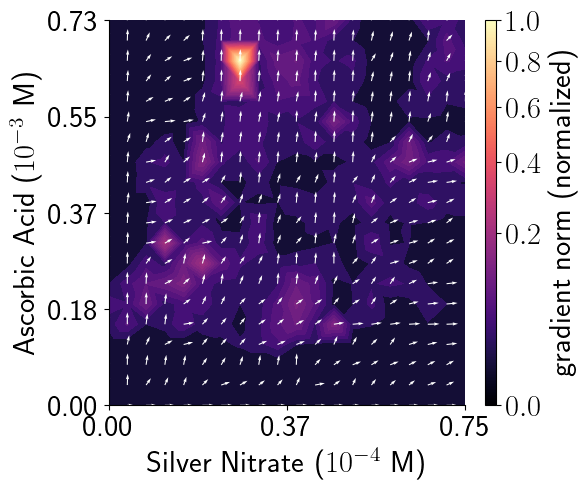

In [23]:
from matplotlib.colors import PowerNorm

gradient_data = np.load("./data/gradient_data.npz")

grid_grad = gradient_data["grid_grad"]
grid_norm = gradient_data["grid_norm"]
grid_data = np.load("./data/grid_data_20.npz")
grid_comps = grid_data["comps"]

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    flags = grid_norm<100.0
    z = grid_norm[flags] /max(grid_norm)
    norm=PowerNorm(gamma=0.5)
    cmap = "magma"
    contour =  ax.tricontourf(grid_comps[flags,0],
                            grid_comps[flags,1], 
                            z,
                            levels=50,
                            cmap = cmap,
                            norm = norm,
                            )
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.2)
    cbar = fig.colorbar(mappable,shrink=0.5, aspect=5,cax=cax)
    cbar.ax.set_ylabel('gradient norm (normalized)', rotation=90)

    U = grid_grad[:,0]
    V = grid_grad[:,1]
    # Normalize the arrows:
    U = U / (grid_norm+1e-3) 
    V = V / (grid_norm+1e-3)
    ax.quiver(grid_comps[:,0], 
            grid_comps[:,1], 
            U, 
            V, 
            color="w",
            lw=2.0,
            units='width'
            )
    prettify_axis(ax)
    plt.show()